In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
# Download the pre processed data set
file_id = '1a2TRcqj5ySMWwetfU3Zgq4FE-highOKK'

destination = 'RAVDESS-train.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [15]:
!ls -lh

total 506M
drwxr-xr-x 3 root root 4.0K Dec 13 08:56 RAVDESS
-rw-r--r-- 1 root root 506M Dec 13 08:56 RAVDESS-train.zip
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 sample_data


In [16]:
!unzip -n RAVDESS-train.zip

Archive:  RAVDESS-train.zip


In [33]:
!ls RAVDESS/train_valid/test -lh

ls: cannot access 'RAVDESS/train_valid/test': No such file or directory


In [0]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import random
import re
import gc
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
def name_to_data(self, path):
    numbers = re.findall(r'\d+', path) # numbers in the name of the audio file
    # spectogram = Image.open(spectogram_path) # consumes too much memory
    return [
        self.emotions[numbers[2]],
        self.emotion_intensities[numbers[3]],
        self.statements[numbers[4]],
        self.repetitions[int(numbers[5])-1],
        numbers[6], 
        self.actors[numbers[6]], 
        path
    ]


# Creates the Data Frame for the RAVDESS
def create_dataframe(self):
    print('Create dataframe')
    data = []
    specograms_paths = self.get_split_image_paths()
    for specograms_path in specograms_paths:
        data.append(self.name_to_data(specograms_path))

    df = pd.DataFrame(  # contruct DataFrame from data
        { 
            'emotion'           : pd.Categorical([row[0] for row in data]),
            'emotion_intensity' : pd.Categorical([row[1] for row in data]),
            'statement'         : pd.Categorical([row[2] for row in data]),
            'repetition'        : pd.Categorical([row[3] for row in data]),
            'actor'             : pd.Categorical([row[4] for row in data]),
            'actor_gender'      : pd.Categorical([row[5] for row in data]),
            'image'             : pd.Categorical([row[6] for row in data])
        })

    # one-hot encode columns
    df = pd.get_dummies(df, columns=["emotion", "emotion_intensity", "statement", "repetition", "actor", "actor_gender"])
    return df

In [0]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [0]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Flatten
import numpy as np

In [0]:
resnet_img_height=128
resnet_img_width=128

In [23]:
# load the pre-trained InceptionV3 model without the fully-connected layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8,activation='softmax')(x)

# for layer in base_model.layers:
#   print(layer)

# create new top layers for the model
# output = base_model.layers[-1].output
# output = Flatten()(output)

# Fully connected layer with Relu activation
# x = Dense(1024, activation='relu')(x)
# base_model.add(Dense(512, activation='relu', input_dim=input_shape))
# base_model.add(Dropout(0.3))
# base_model.add(Dense(512, activation='relu'))
# base_model.add(Dropout(0.3))

# The output layer has 8 neurons, as we have 8 different emotion in the data set. The activation is set to softmax.
# predictions = Dense(8, activation='softmax')(x)

# Finalize the model
model = Model(inputs=base_model.input, outputs=predictions)



/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step



In [24]:
for layer in base_model.layers:
    layer.trainable = False

# We use categorical_crossentropy as we have multiple classes
model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

In [25]:
print("Number of original train images: " + str(sum([len(files) for r, d, files in os.walk(train_dir)])))
print("Number of original validation images: " + str(sum([len(files) for r, d, files in os.walk(validation_dir)])))
print("Number of original test images: " + str(sum([len(files) for r, d, files in os.walk(test_dir)])))

Number of original train images: 28701
Number of original validation images: 12306
Number of original test images: 0


In [26]:
# Load the images with ImageDataGenerator. The original images are not augmented as we have a fixed time series images. The Image is rescaled to 0..1 range.
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)

Found 28701 images belonging to 8 classes.
Found 12306 images belonging to 8 classes.


In [27]:
# The model used the train generator to load and randomize the data. 
model.fit(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
5/5 [==============================] - 51s 10s/step - loss: 8.6892 - acc: 0.1375 - val_loss: 2.7250 - val_acc: 0.1406
Epoch 2/5
5/5 [==============================] - 40s 8s/step - loss: 11.2018 - acc: 0.1438 - val_loss: 2.5834 - val_acc: 0.0938
Epoch 3/5
5/5 [==============================] - 40s 8s/step - loss: 9.4433 - acc: 0.1750 - val_loss: 2.2770 - val_acc: 0.1437
Epoch 4/5
5/5 [==============================] - 40s 8s/step - loss: 7.2157 - acc: 0.1313 - val_loss: 2.4279 - val_acc: 0.1313
Epoch 5/5
5/5 [==============================] - 40s 8s/step - loss: 5.8945 - acc: 0.1313 - val_loss: 2.4348 - val_acc: 0.1344


In [28]:
# Allow the upper layers of the InceptionV3 model to be trained
summ= 0
for layer in model.layers[:89]:
  layer.trainable = False
  summ+=1
for layer in model.layers[89:]:
  layer.trainable = True
  summ+=1

print(summ)

178


In [0]:
# We recompile the model to take affect
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='categorical_crossentropy')

In [30]:
history = model.fit_generator(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=15)

Epoch 1/15
5/5 [==============================] - 70s 14s/step - loss: 6.1565 - acc: 0.1500 - val_loss: 12.0302 - val_acc: 0.1156
Epoch 2/15
5/5 [==============================] - 58s 12s/step - loss: 5.7093 - acc: 0.1625 - val_loss: 12.9145 - val_acc: 0.0938
Epoch 3/15
5/5 [==============================] - 58s 12s/step - loss: 4.9912 - acc: 0.1812 - val_loss: 10.6970 - val_acc: 0.1344
Epoch 4/15
5/5 [==============================] - 58s 12s/step - loss: 5.5003 - acc: 0.1125 - val_loss: 12.9169 - val_acc: 0.1531
Epoch 5/15
5/5 [==============================] - 58s 12s/step - loss: 5.3168 - acc: 0.2063 - val_loss: 13.4789 - val_acc: 0.1469
Epoch 6/15
5/5 [==============================] - 58s 12s/step - loss: 4.6299 - acc: 0.2312 - val_loss: 13.1383 - val_acc: 0.1688
Epoch 7/15
5/5 [==============================] - 58s 12s/step - loss: 6.7697 - acc: 0.1438 - val_loss: 13.5434 - val_acc: 0.1219
Epoch 8/15
5/5 [==============================] - 58s 12s/step - loss: 5.0461 - acc: 0.212

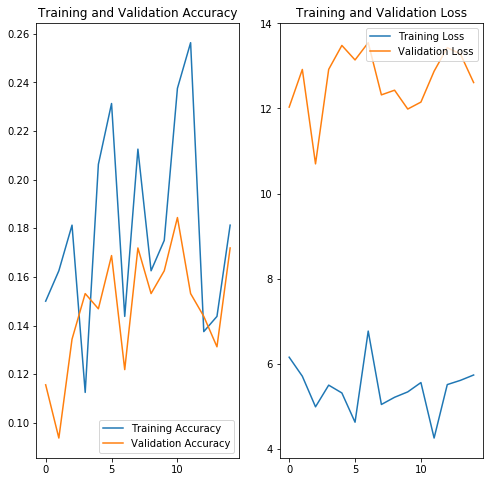

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
# test_generator = test_datagen.flow_from_directory(test_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)
# scores = model.evaluate_generator(test_generator)
# print("Accuracy = ", scores[1])

In [0]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

In [0]:
# conf= confusion_matrix(y_test,np.argmax(preds,axis=1))

# sns.set()
# sns.heatmap(conf)
